In [ ]:
!pip install nibabel
import os
import random
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nibabel as nib


DATA_DIR = Path("Your data directory")
RANDOM_SEED = 1234
random.seed(RANDOM_SEED)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir /datasets -p
from google.colab import drive
drive.mount('/datasets/drive', force_remount=True)

Mounted at /datasets/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True) #Necessary for Grad-CAM

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Display
from IPython.display import Image, display
import matplotlib.cm as cm
from PIL import Image
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_jet_heatmap(img, heatmap, alpha= 0.8):
  # Rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
  return jet_heatmap

  # Display Grad CAM
  #display(Image(cam_path)) 

def get_superimposed(img, heatmap, alpha=0.5):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)
    return superimposed_img

    # Display Grad CAM
    #display(Image(cam_path))

# Produce a tensor(img) to give to the model and a (w,h,1) img starting from a grayscale
def get_img_array(img_path):
    gray = np.expand_dims(img_path, axis=-1)
    img = np.expand_dims(img_path, axis=[0,-1])
    return img,gray

def to_rgb(img):
  norm = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

  # convert to 3 channel
  norm = cv2.cvtColor(norm, cv2.COLOR_GRAY2BGR)
  return norm

def get_masked(img, superimposed):
  blurred = cv2.GaussianBlur(img, (21, 21), 150) # 5(55,55), 50 seems to work fine with PET
  blurred =  blurred * 255.0 / blurred.max()
  blurred[np.where(blurred < 0)] = 0
  blurred = blurred.astype(np.uint8)
  ret, thres = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  mask = cv2.medianBlur(thres, 1)
  array_img = np.asarray(superimposed)
  rgb_mask = to_rgb(mask)
  result = cv2.bitwise_and(array_img, rgb_mask)
  return result

def plot_heatmap(src, heatmap, dest):
  plt.figure(figsize=(12, 3))
  ax = plt.subplot(1, 3, 1)
  #rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(src, cmap='gray')
  plt.axis('off')
  plt.title('Original Image')
  ax = plt.subplot(1, 3, 2)
  plt.imshow(heatmap)
  plt.axis('off')
  plt.title(f'{layer_name} Grad-CAM heat-map')
  ax = plt.subplot(1, 3, 3)
  plt.axis('off')
  plt.title('Superimposed Image')
  plt.imshow(dest)
  plt.tight_layout()


def grad_2d(sample,layer_name='conv2d_3'):
  arr = []
  for scan in sample:
    tensor,img = get_img_array(scan)
    heatmap = make_gradcam_heatmap(tensor, model, layer_name)
    #grad_cam=GradCam(model,tensor,layer_name)
    rgb = to_rgb(scan)
    final = get_jet_heatmap(rgb, heatmap,0.5)
    #grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)
    # TO REMOVE COMMENT final = get_masked(img, superimposed)
    #plot_heatmap(scan,heatmap,final)
    arr.append(final)

    #return final
  #plot_frames(arr)
  return np.array(arr)

def grad_single_scan(scan,layer_name='conv2d_3'):
  tensor,img = get_img_array(scan)
  heatmap = make_gradcam_heatmap(tensor, model, layer_name)
  #grad_cam=GradCam(model,tensor,layer_name)
  rgb = to_rgb(scan)
  superimposed = get_superimposed(rgb, heatmap, 0.5)
  #grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)
  final = get_masked(img, superimposed)
  plot_heatmap(scan,heatmap,final)
  #return final

def plot_frames(arr):
  fig = plt.figure(figsize=(20, 20))
  columns = 10
  rows = 3
  for i in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(arr[i-1].astype(np.uint8))
  plt.show()

def plot_frames2(arr):
  fig = plt.figure(figsize=(20, 20))
  columns = 10
  rows = 4
  for i in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(arr[i-1][:,:,25].astype(np.uint8))
  plt.show()

def overlay(arr):
  mean = np.mean(arr, axis=0, dtype=np.float64)
  return mean

def conc_frames(arr):
  heatmaps = grad_2d(arr, 'conv2d_3')
  array = np.array(heatmaps)
  overlay_heatmaps = overlay(array)
  return overlay_heatmaps

def binarize_scan(img):
    blurred = cv2.GaussianBlur(img, (51, 51), 50)
    blurred = blurred.astype(np.float64)
    blurred *= 255.0 / blurred.max()
    blurred[np.where(blurred < 0)] = 0
    blurred = blurred.astype(np.uint8)
    ret, thres = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blurred_thres = cv2.medianBlur(thres, 51)
    return blurred_thres

def binarize(img):
  l = []
  for slice_img in img.T:
    blurred = cv2.GaussianBlur(slice_img.T, (51, 51), 50)
    blurred = blurred.astype(np.float64)
    blurred *= 255.0 / blurred.max()
    blurred[np.where(blurred < 0)] = 0
    blurred = blurred.astype(np.uint8)
    ret, thres = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blurred_thres = cv2.medianBlur(thres, 51)
    l.append(blurred_thres)
    arr = np.array(l)
    mean = overlay(arr)
  return mean

# PET scans

In [ ]:
from PIL import Image

layer_name = 'conv2d_3' # Select the Layer to visualize
path = DATA_DIR / 'pet/folds/validation/memento-pet.h5'
path_3d = DATA_DIR / 'pet/3d-folds/3d-pet.h5'
model = new_model = tf.keras.models.load_model(path_3d)
model.layers[-1].activation = None
base = DATA_DIR / 'pet/'
xtest = np.load(base / '50-xtest.npy')
ytest = np.load(base / '50-ytest.npy')
x_sample = xtest
y_sample = ytest
neg = x_sample[:30]
pos = x_sample[30:]
print(neg.shape, pos.shape)
print(y_sample)

(30, 128, 128, 50) (30, 128, 128, 50)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# MRI Scans

In [ ]:
layer_name = 'conv3d_3' # Select the Layer to visualize
path_3d = DATA_DIR / 'mri/validation/50-mri.h5'
path = DATA_DIR / 'mri/memento-mri-validation.h5'
model = new_model = tf.keras.models.load_model(path_3d)
model.layers[-1].activation = None
base = DATA_DIR / 'mri/'
pos = np.load(DATA_DIR/'mri/new-pos.npy')
neg = np.load(DATA_DIR/'mri/new-neg.npy')
pos = np.delete(pos, [18,19,20], axis=0)
pos = pos[:30]
neg = neg[:30]
print(pos.shape,neg.shape)
#grad_2d(pos,layer_name)

(30, 128, 128, 50) (30, 128, 128, 50)


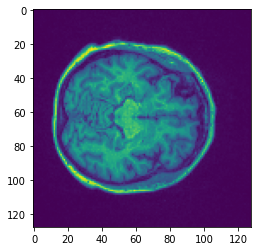

In [ ]:
plt.imshow(neg[0][:,:,25])

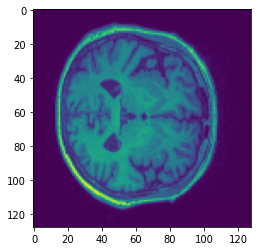

In [ ]:
plt.imshow(neg[15][:,:,25])

# tf-keras-vis

In [ ]:
!pip install tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.2 MB/s 


In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0, 0, 0, 0, 0])

data = np.expand_dims(pos,-1)

In [ ]:
model.layers[-7].name

'conv3d_3'

In [ ]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

model_3d = tf.keras.models.load_model(path_3d) 


# Create Gradcam object
gradcam = Gradcam(model_3d,
                  clone=True)
# Generate heatmap with GradCAM
#cam = gradcam(score,
#              tf.expand_dims(pos[:5], axis=-1),
#              penultimate_layer=-7)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

In [ ]:
maps = np.empty(shape=(1,128,128,50))
for i in range(0,30,5):
  cam = gradcam(score, tf.expand_dims(neg[i:i+5], axis=-1), penultimate_layer=-7)
  maps = np.append(maps, cam, axis=0)
maps = np.delete(maps, [0], axis=0)
maps.shape

(30, 128, 128, 50)

In [ ]:
for i in range(30):
  plt.imshow(maps[i][:,:,25], cmap='jet')
  plt.pause(0.5)

In [ ]:
for i in range(30):
  plt.imshow(maps[i][:,:,25], cmap='jet')
  plt.pause(0.5)

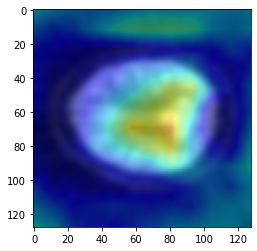

In [ ]:
plt.imshow(pos[3][:,:,25], cmap='gray', alpha=1)
heatmap = np.uint8(cm.jet(cam[3])[..., :3] * 255)
plt.imshow(heatmap[:,:,25], cmap='jet', alpha=0.5)

In [ ]:
# Render
f, ax = plt.subplots(nrows=6, ncols=5, figsize=(12, 4))
for i in range(30):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    #ax[i].imshow(pos[i][:,:,25])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
np.save(DATA_DIR/'mri/neg_mri_heat.npy', maps)

In [ ]:
f = np.load(DATA_DIR/'mri/pos_mri_heat.npy')
f.shape

(30, 128, 128, 50)

In [ ]:
neg_mean_mri = overlay(maps)
plt.imshow(neg_mean_mri[:,:,25], cmap='jet')

In [ ]:
plt.imshow(pos_mean_mri[:,:,25], cmap='jet')

In [ ]:
pos_mean_mri = overlay(maps)
plt.imshow(pos_mean_mri[:,:,25], cmap='jet')

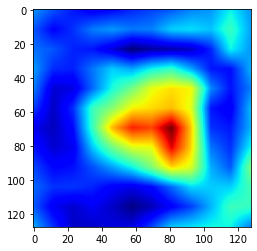

In [ ]:
plt.imshow(pos_mean_pet[:,:,25], cmap='jet')

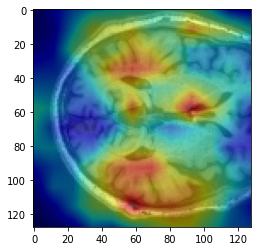

In [ ]:
plt.imshow(pos[2][:,:,25], cmap='gray')
plt.imshow(pos_mean_mri[:,:,25], cmap='jet', alpha=0.5)

In [ ]:
np.save(DATA_DIR/'pet/neg_mean_mri.npy', neg_mean_mri)